In [1]:
import numpy as np
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('msft.csv')

# Calculate the daily log returns of the stock
df['LogReturns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# Calculate the daily volatility (standard deviation of log returns)
sigma_daily = df['LogReturns'].std()

# Annualize the daily volatility (assuming 252 trading days in a year)
sigma_annual = sigma_daily * np.sqrt(252)

# Parameters
r = 0.05  # Example risk-free rate
T = 1  # Time to maturity (in years)
nrun = 100  # Number of periods
dt = T / nrun  # Time step
mu = r + 0.5 * sigma_annual ** 2  # Drift term

# Calculate up and down factors
u = np.exp(mu * dt + sigma_annual * np.sqrt(dt))  # Up factor
d = np.exp(mu * dt - sigma_annual * np.sqrt(dt))  # Down factor

#u = 1.2
#d = 1/u

# Calculate the risk-neutral probability
p = (np.exp(r * dt) - d) / (u - d)

# Calculate the future stock prices after an up move and a down move
f_u = u * df['Adj Close'].iloc[-1]
f_d = d * df['Adj Close'].iloc[-1]

# Calculate the present value of the expected future stock price
f = np.exp(-r * T) * (p * f_u + (1 - p) * f_d)

# Set the initial stock price to the last adjusted closing price in the DataFrame
S0 = df['Adj Close'].iloc[-1]

# Example strike price
K = 450

# Building the Stock Price Tree

In [3]:
# Function to build the stock price tree
def build_stock_price_tree(S0, nrun, u, d):
    stock_prices = np.zeros((nrun + 1, nrun + 1))
    stock_prices[0, 0] = S0
    for j in range(1, nrun + 1):
        for i in range(j + 1):
            if i == 0:
                stock_prices[i, j] = stock_prices[i, j - 1] * u
            else:
                stock_prices[i, j] = stock_prices[i - 1, j - 1] * d
    return stock_prices

# Computing Option Prices

In [5]:
# Function to compute the put option price based on a given S0
def compute_option_price(stock_prices, K, nrun, p, r, dt):
    # Initialize option price tree
    option_values = np.zeros((nrun + 1, nrun + 1))
    
    # Compute final option values at maturity
    for i in range(nrun + 1):
        option_values[i, nrun] = max(0, K - stock_prices[i, nrun])  # Payoff for put option

    # Step back through the tree
    for j in range(nrun - 1, -1, -1):
        for i in range(j + 1):
            # Calculate the discounted theoretical value
            discounted_value = np.exp(-r * dt) * (p * option_values[i, j + 1] + (1 - p) * option_values[i + 1, j + 1])
            payoff = max(0, K - stock_prices[i, j])
            option_values[i, j] = max(payoff, discounted_value) 

    return option_values

# Adjusting S0 Until Convergence

In [7]:
from wakepy import keep

# Set initial values
initial_S0 = S0
adjustment_factor = 0.01  # delta
epsilon = 1e-1  # Convergence threshold
iteration = 0
direction = -1  # Start by decreasing S0

# Keeping the system awake during the long-running task
with keep.running(on_fail='warn'):
    while True:
        iteration += 1

        # Build the stock price tree based on the current S0
        stock_prices = build_stock_price_tree(S0, nrun, u, d)

        # Compute the option prices based on the updated stock price tree
        option_values = compute_option_price(stock_prices, K, nrun, p, r, dt)

        # Calculate the discounted option value at the root node (0,0)
        f_0 = np.exp(-r * dt) * (p * option_values[0, 1] + (1 - p) * option_values[1, 1])
        max_payoff_0 = max(0, K - S0)

        # Check the convergence condition
        if abs(f_0 - max_payoff_0) < epsilon:
            break
        else:
            # Adjust S0 based on direction
            S0 += direction * adjustment_factor

            if S0 <= 0:
                # Reset to initial value and change direction to increasing S0
                S0 = initial_S0
                direction = 1  # Change direction to increasing S0

            if S0 >= K:
                # Stop the iteration if S0 exceeds the strike price K
                break

print("Final Adjusted S0:", S0)
print("Option Prices Tree:\n", option_values)
print("Stock Prices Tree:\n", stock_prices)

Final Adjusted S0: 315.8299880000782
Option Prices Tree:
 [[134.26959179 124.7836081  115.48158052 ...   0.           0.
    0.        ]
 [  0.         143.32662804 133.65832561 ...   0.           0.
    0.        ]
 [  0.           0.         152.21777335 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 432.32829657 431.7656244
  431.1850366 ]
 [  0.           0.           0.         ...   0.         432.84063868
  432.29427964]
 [  0.           0.           0.         ...   0.           0.
  433.33812685]]
Stock Prices Tree:
 [[ 315.829988    325.88610641  336.26241454 ... 6815.16799292
  7032.16491819 7256.07108849]
 [   0.          306.67337196  316.43794106 ... 6413.37727441
  6617.58106669 6828.28676693]
 [   0.            0.          297.78222665 ... 6035.27427448
  6227.43915759 6425.72262631]
 ...
 [   0.            0.            0.         ...   17.67170343
    18.2343756    18.8149634 ]
 [   0.            0.            0.         ...   

# Final Tree Plotting (First 6 columns only)

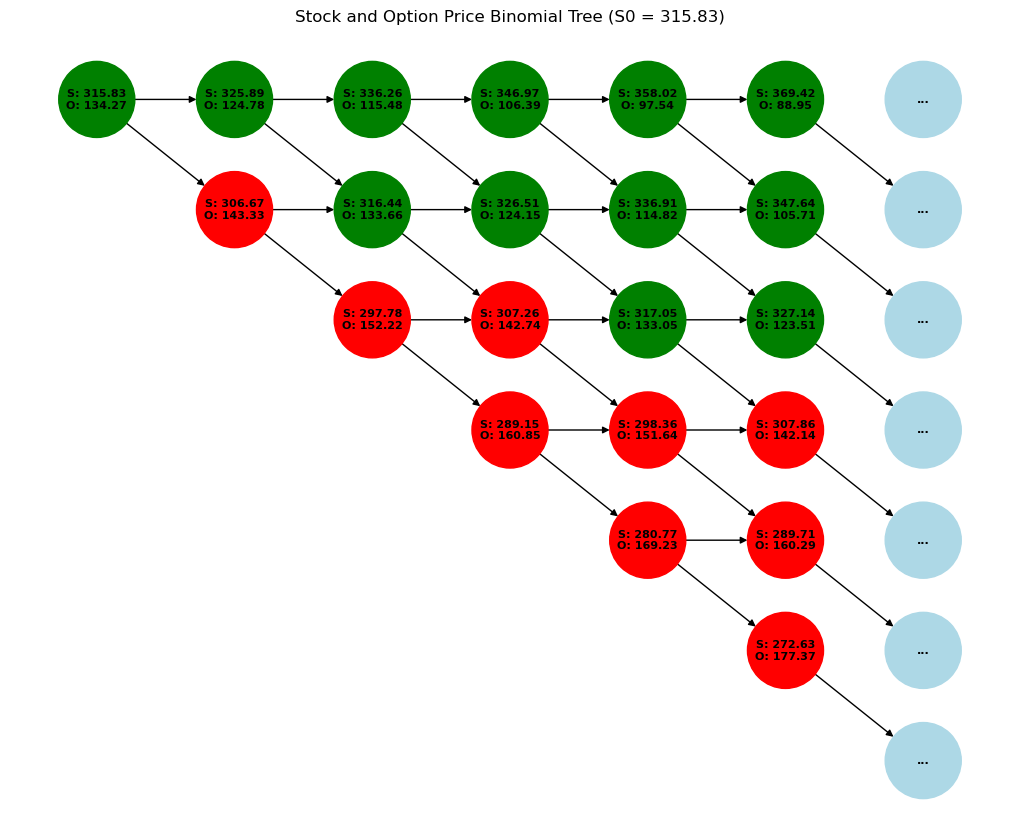

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

columns_to_plot = 6
# Function to plot the stock price and option price tree with ellipses and colored nodes
def plot_price_tree_partial(stock_prices, option_values, S0, K, nrun, columns_to_plot):
    G = nx.DiGraph()
    pos = {}
    labels = {}
    node_colors = []

    for j in range(columns_to_plot):
        for i in range(j + 1):
            intrinsic_value = max(K - stock_prices[i, j], 0)
            if option_values[i, j] == intrinsic_value:
                color = 'red'
            else:
                color = 'green'
            
            node_colors.append(color)
            labels[(i, j)] = f'S: {stock_prices[i, j]:.2f}\nO: {option_values[i, j]:.2f}'
            pos[(i, j)] = (j, -i)
            G.add_node((i, j))
            if j > 0:
                if i < j:
                    G.add_edge((i, j - 1), (i, j))
                if i > 0:
                    G.add_edge((i - 1, j - 1), (i, j))

    # Add ellipses to indicate that the tree continues
    for i in range(columns_to_plot + 1):
        labels[(i, columns_to_plot)] = '...'
        pos[(i, columns_to_plot)] = (columns_to_plot, -i)
        G.add_node((i, columns_to_plot))
        node_colors.append('lightblue')
        if i > 0:
            G.add_edge((i - 1, columns_to_plot - 1), (i, columns_to_plot))

    # Plot the graph
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color=node_colors, font_size=8, font_weight='bold')
    plt.title(f"Stock and Option Price Binomial Tree (S0 = {S0:.2f})")
    plt.show()

# Plot the final adjusted tree
plot_price_tree_partial(stock_prices, option_values, S0, K, nrun, columns_to_plot)


# Free Boundary Path

In [11]:
# Initialize a list to store the results for each time step
results = []

# Iterate through the nodes of the tree at each time step
for j in range(1, nrun):  # Iterate through each time step, excluding the first and last time steps
    for i in range(j):  # Iterate through nodes at the current time step, up to j-1 (to compare i and i+1)
        # Calculate the payoff at the i-th and (i+1)-th nodes
        payoff_i = max(0, K - stock_prices[i, j])
        payoff_next = max(0, K - stock_prices[i + 1, j])

        # Check if the conditions are met
        if option_values[i, j] > payoff_i and option_values[i + 1, j] <= payoff_next:
            stock_price_i = stock_prices[i, j]
            stock_price_next = stock_prices[i + 1, j]
            results.append((j, i, stock_price_i, stock_price_next))  # Store the result
            break  # Move to the next time step once a match is found in the current column

# Output the results for each column
if results:
    for j, i, stock_price_i, stock_price_next in results:
        print(f"Time step {j}:")
        print(f"  Stock price at i-th node where option_values > max(K - S_t^(i)): {stock_price_i:.2f}")
        print(f"  Stock price at (i+1)-th node where option_values <= max(K - S_t^(i+1)): {stock_price_next:.2f}")
else:
    print("No such nodes found in the tree.")

Time step 1:
  Stock price at i-th node where option_values > max(K - S_t^(i)): 325.89
  Stock price at (i+1)-th node where option_values <= max(K - S_t^(i+1)): 306.67
Time step 2:
  Stock price at i-th node where option_values > max(K - S_t^(i)): 316.44
  Stock price at (i+1)-th node where option_values <= max(K - S_t^(i+1)): 297.78
Time step 3:
  Stock price at i-th node where option_values > max(K - S_t^(i)): 326.51
  Stock price at (i+1)-th node where option_values <= max(K - S_t^(i+1)): 307.26
Time step 4:
  Stock price at i-th node where option_values > max(K - S_t^(i)): 317.05
  Stock price at (i+1)-th node where option_values <= max(K - S_t^(i+1)): 298.36
Time step 5:
  Stock price at i-th node where option_values > max(K - S_t^(i)): 327.14
  Stock price at (i+1)-th node where option_values <= max(K - S_t^(i+1)): 307.86
Time step 6:
  Stock price at i-th node where option_values > max(K - S_t^(i)): 317.66
  Stock price at (i+1)-th node where option_values <= max(K - S_t^(i+1)):

# Plotting Free Boundary Path

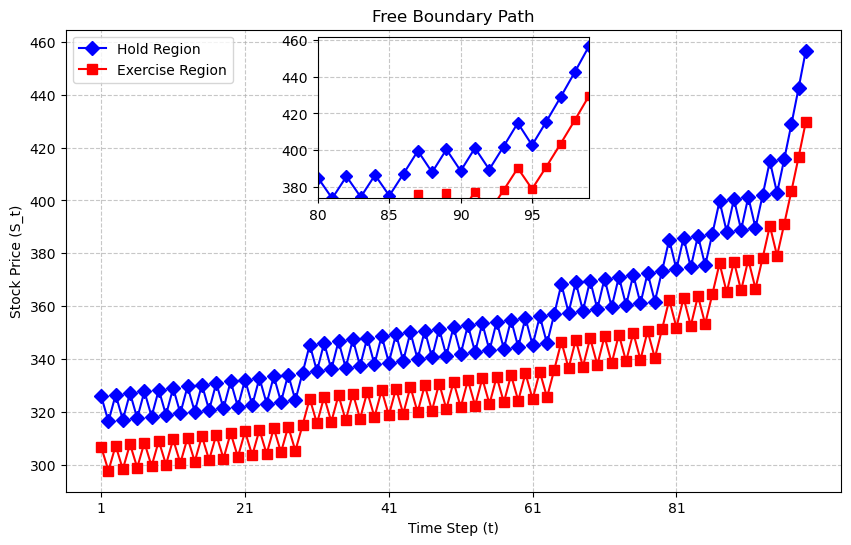

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Initialize lists to store the time steps and corresponding stock prices
time_steps = []
S_t_i_values = []
S_t_i_plus_1_values = []

# Assuming `results` contains the data from your previous analysis
# Iterate over the results and extract the time steps and stock prices
for j, i, stock_price_i, stock_price_next in results:
    time_steps.append(int(j))  # Ensure time steps are integers
    S_t_i_values.append(stock_price_i)
    S_t_i_plus_1_values.append(stock_price_next)

# Create the main figure
plt.figure(figsize=(10, 6))

# Plot the main graph with markers
plt.plot(time_steps, S_t_i_values, 'bD-', label="Hold Region", markersize=7)
plt.plot(time_steps, S_t_i_plus_1_values, 'rs-', label="Exercise Region", markersize=7)

# Labels and title
plt.xlabel('Time Step (t)')
plt.ylabel('Stock Price (S_t)')
plt.title('Free Boundary Path')

# Set x-ticks to intervals of 20
plt.xticks(range(min(time_steps), max(time_steps)+1, 20))  # Set x-ticks every 20 time steps

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Create an inset plot (zoomed-in view for the last 30 time steps)
ax_inset = inset_axes(plt.gca(), width="35%", height="35%", loc='upper center')  # Change to bottom right

# Focus on the last 20 time steps (adjust this as needed)
num_steps = len(time_steps)
start_zoom = num_steps - 20

ax_inset.plot(time_steps[start_zoom:], S_t_i_values[start_zoom:], 'bD-', markersize=6)
ax_inset.plot(time_steps[start_zoom:], S_t_i_plus_1_values[start_zoom:], 'rs-', markersize=6)

# Set zoomed-in x and y limits based on the last 20 points
ax_inset.set_xlim(time_steps[start_zoom], time_steps[-1])
ax_inset.set_ylim(min(S_t_i_values[start_zoom:]), max(S_t_i_values[start_zoom:]) + 5)
ax_inset.grid(True, linestyle='--', alpha=0.7)

plt.savefig('Free_Boundary_Path_with_Inset.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
